# Lab 8 Data Analysis
Group: IP-91

Var: 6

Students:
- Geleshko D.
- Vlasov A.

## Import

In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

## Config

In [136]:
np.random.seed(6)

plt.rcParams["figure.figsize"] = (16, 8)

pd.set_option("display.max_columns", None)
pd.options.display.float_format ="{:,.3f}".format

# Data

## Load Data

In [137]:
df = pd.read_csv("../data/blood.csv", dtype=np.int32)
df.columns = df.columns.map(lambda x: str.lower(x))
df

,recency,frequency,monetary,time,class
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0
...,...,...,...,...,...
743,23,2,500,38,0
744,21,2,500,52,0
745,23,3,750,62,0
746,39,1,250,39,0


## Data Info

In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   recency    748 non-null    int32
 1   frequency  748 non-null    int32
 2   monetary   748 non-null    int32
 3   time       748 non-null    int32
 4   class      748 non-null    int32
dtypes: int32(5)
memory usage: 14.7 KB


In [139]:
df.nunique()

recency      31
frequency    33
monetary     33
time         78
class         2
dtype: int64

## Plots

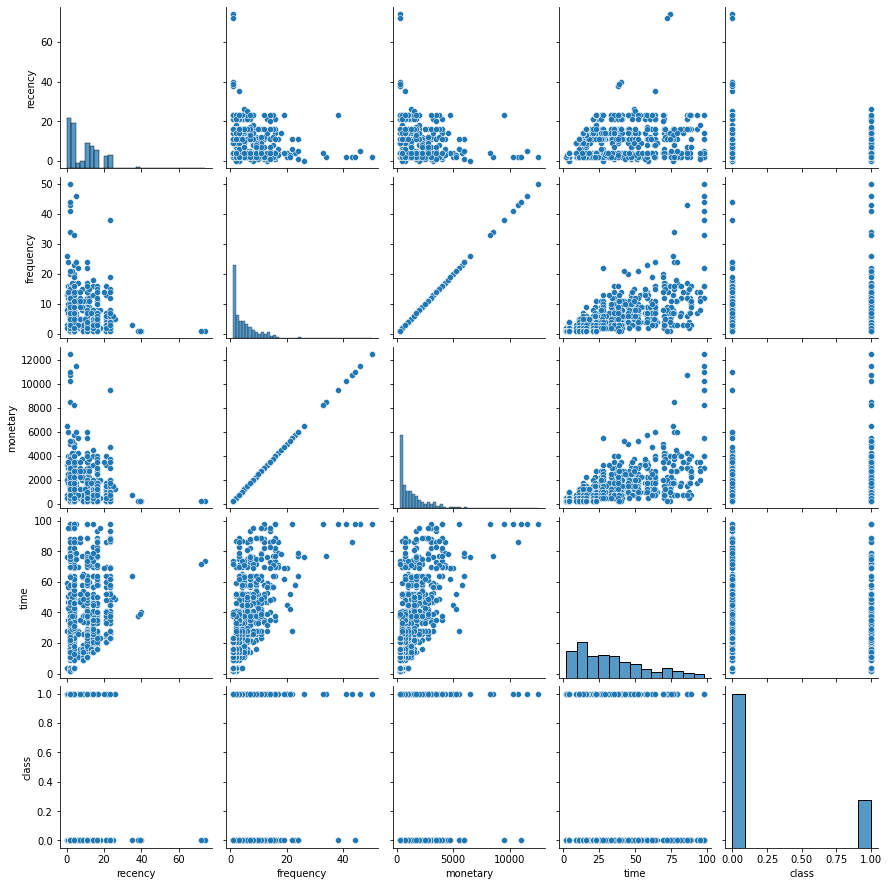

In [140]:
sns.pairplot(df)
plt.show()

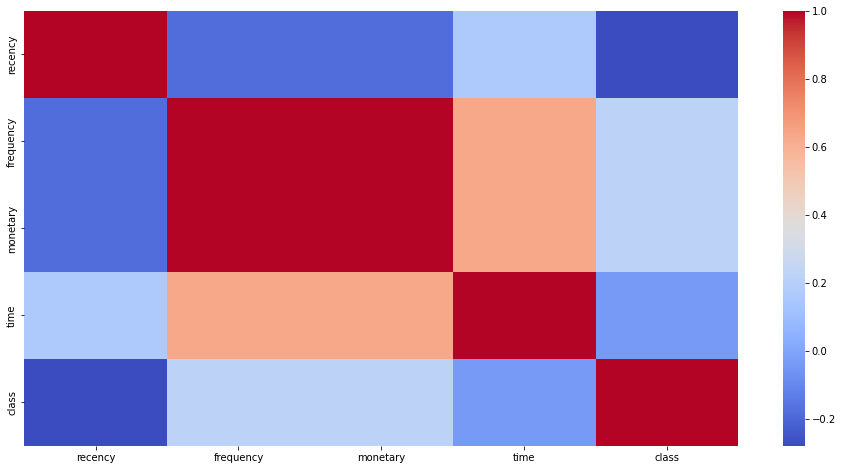

In [141]:
corr = df.corr()

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap="coolwarm")
plt.show()

## Feature Selection

In [142]:
df = df.drop("monetary", axis=1)
df

,recency,frequency,time,class
0,2,50,98,1
1,0,13,28,1
2,1,16,35,1
3,2,20,45,1
4,1,24,77,0
...,...,...,...,...
743,23,2,38,0
744,21,2,52,0
745,23,3,62,0
746,39,1,39,0


## Normalization

In [143]:
features = ["recency", "frequency", "time"]

df[features] = (df[features] - df[features].mean()) / df[features].std()

## Train/Test Split

In [144]:
X = df[features].values.astype(np.float32)
y = df["class"].values.astype(np.float32)

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100)
y_train.shape, y_test.shape

((648,), (100,))

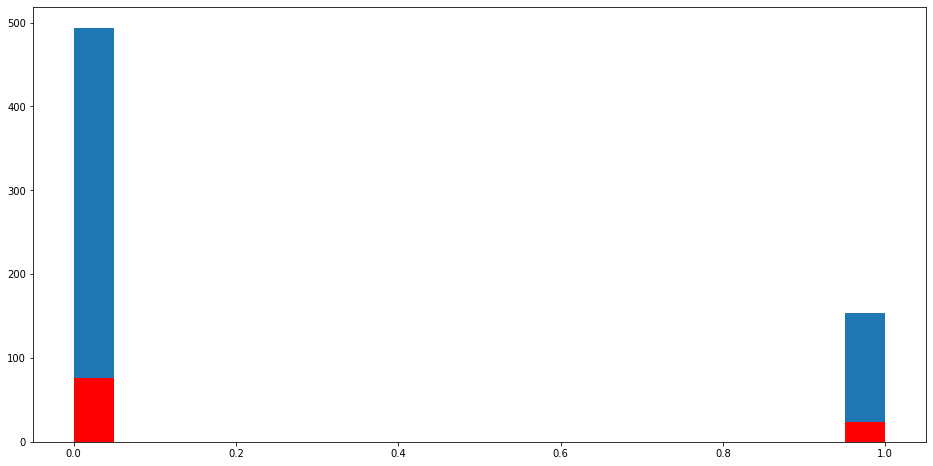

In [146]:
plt.hist(y_train, bins=20)
plt.hist(y_test, bins=20, color="red")
plt.show()

## Preview

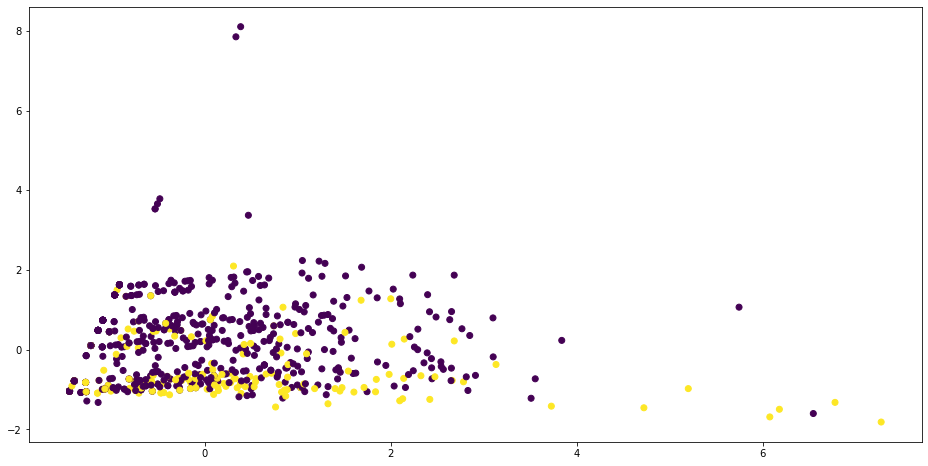

In [157]:
pca = PCA(n_components=2)
X_transform = pca.fit_transform(X, y)
plt.scatter(X_transform[:, 0], X_transform[:, 1], c=y)
plt.show()

# Prediction

In [147]:
def evaluate(y_train, y_train_hat, y_test, y_test_hat):
    return pd.DataFrame([
        [accuracy_score(y_train, y_train_hat),
        f1_score(y_train, y_train_hat),
        precision_score(y_train, y_train_hat),
        recall_score(y_train, y_train_hat)],
        
        [accuracy_score(y_test, y_test_hat),
        f1_score(y_test, y_test_hat),
        precision_score(y_test, y_test_hat),
        recall_score(y_test, y_test_hat)]
        ], index=["Train", "Test"], columns=["Accuracy", "F1", "Precision", "Recall"])

## Logistic Regression

In [148]:
lr = LogisticRegression(class_weight="balanced")
lr.fit(X_train, y_train)
evaluate(y_train, lr.predict(X_train), y_test, lr.predict(X_test))

,Accuracy,F1,Precision,Recall
Train,0.660,0.515,0.390,0.760
Test,0.670,0.548,0.408,0.833


## Decision Tree Classifier

In [149]:
parametersGrid = {
    "splitter" : ["best"],
    "max_depth": [2, 3, 5],
    "min_samples_leaf": [5, 7, 10]}

grid_dtc = GridSearchCV(DecisionTreeClassifier(), parametersGrid, scoring="f1", cv=10, n_jobs=-1)
grid_dtc.fit(X_train, y_train)

dtc = grid_dtc.best_estimator_
print(dtc)
evaluate(y_train, dtc.predict(X_train), y_test, dtc.predict(X_test))

DecisionTreeClassifier(max_depth=3, min_samples_leaf=5)


,Accuracy,F1,Precision,Recall
Train,0.801,0.486,0.629,0.396
Test,0.760,0.455,0.500,0.417


## SVC

In [150]:
parametersGrid = {
    "kernel": ["poly", "rbf", "sigmoid"], # def rbf
    "class_weight": ["balanced"],
    "probability": [True]}

grid_svc = GridSearchCV(SVC(), parametersGrid, scoring="f1", cv=10, n_jobs=-1)
grid_svc.fit(X_train, y_train)

svc = grid_svc.best_estimator_

print(svc)
evaluate(y_train, svc.predict(X_train), y_test, svc.predict(X_test))

SVC(class_weight='balanced', probability=True)


,Accuracy,F1,Precision,Recall
Train,0.693,0.530,0.416,0.727
Test,0.700,0.531,0.425,0.708


## KNN

In [151]:
parametersGrid = {
    "n_neighbors": [3, 5, 7, 9], # def 3
    "weights": ["uniform", "distance"]} # def uniform

grid_knn = GridSearchCV(KNeighborsClassifier(), parametersGrid, scoring="f1", cv=10, n_jobs=-1)
grid_knn.fit(X_train, y_train)

knn = grid_knn.best_estimator_

print(knn)
evaluate(y_train, knn.predict(X_train), y_test, knn.predict(X_test))

KNeighborsClassifier()


,Accuracy,F1,Precision,Recall
Train,0.815,0.531,0.667,0.442
Test,0.770,0.439,0.529,0.375


## Compare

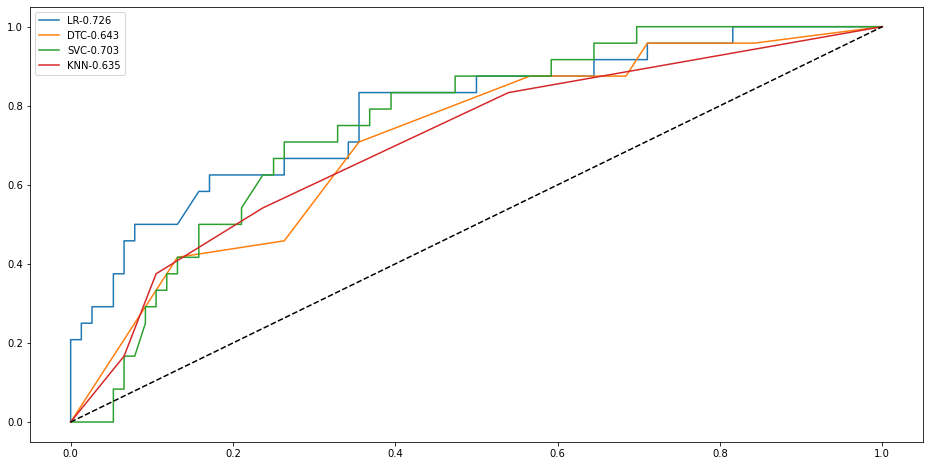

In [152]:
# LR
fpr, tpr, thresh = roc_curve(y_test, lr.predict_proba(X_test)[:, 1])
auc = roc_auc_score(y_test, lr.predict(X_test))
plt.plot(fpr, tpr, label="LR-{}".format(round(auc, 3)))
# DTC
fpr, tpr, thresh = roc_curve(y_test, dtc.predict_proba(X_test)[:, 1])
auc = roc_auc_score(y_test, dtc.predict(X_test))
plt.plot(fpr, tpr, label="DTC-{}".format(round(auc, 3)))
# SVC
fpr, tpr, thresh = roc_curve(y_test, svc.predict_proba(X_test)[:, 1])
auc = roc_auc_score(y_test, svc.predict(X_test))
plt.plot(fpr, tpr, label="SVC-{}".format(round(auc, 3)))
# KNN
fpr, tpr, thresh = roc_curve(y_test, knn.predict_proba(X_test)[:, 1])
auc = roc_auc_score(y_test, knn.predict(X_test))
plt.plot(fpr, tpr, label="KNN-{}".format(round(auc, 3)))
###
plt.plot([0, 1], [0, 1], "--", color="black")
plt.legend()
plt.show()